# **Convolution Assignment**

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"teja0369","key":"2d61f9c22f30b1f67a6950525837d1c6"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

100% 811M/812M [00:03<00:00, 262MB/s]
100% 812M/812M [00:03<00:00, 243MB/s]


Image replication to test, validation, and training directories

In [4]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=667, end_index=1667)
make_subset("validation", start_index=1668, end_index=2168)
make_subset("test", start_index=2169, end_index=2669)

Implementing image_dataset_from_directory To comprehend photographs

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_d = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_d = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_d = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Data preparation

In [6]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [7]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [8]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [9]:
reshaped_d = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_d):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [10]:
for data_batch, labels_batch in train_d:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Constructing model

Comparing dogs and cats using a tiny convolutional neural network

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Preparing the model for training

In [12]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

Outlining the forms and labels the dataset generated

Fitting a model with a dataset

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_d,
    epochs=100,
    validation_data=validation_d,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 19s 279ms/step - loss: 0.6943 - accuracy: 0.5150 - val_loss: 0.6867 - val_accuracy: 0.5800
Epoch 2/100
63/63 [==============================] - 17s 273ms/step - loss: 0.6774 - accuracy: 0.5890 - val_loss: 0.7077 - val_accuracy: 0.5310
Epoch 3/100
63/63 [==============================] - 17s 273ms/step - loss: 0.6557 - accuracy: 0.6100 - val_loss: 0.7100 - val_accuracy: 0.5770
Epoch 4/100
63/63 [==============================] - 17s 267ms/step - loss: 0.6437 - accuracy: 0.6385 - val_loss: 0.6212 - val_accuracy: 0.6790
Epoch 5/100
63/63 [==============================] - 17s 266ms/step - loss: 0.5929 - accuracy: 0.6845 - val_loss: 0.5964 - val_accuracy: 0.7070
Epoch 6/100
63/63 [==============================] - 17s 266ms/step - loss: 0.5662 - accuracy: 0.7160 - val_loss: 0.6359 - val_accuracy: 0.6710
Epoch 7/100
63/63 [==============================] - 17s 268ms/step - loss: 0.5607 - accuracy: 0.7120 - val_loss: 0.5780 - val_accuracy:

Displaying the training accuracy and loss curves

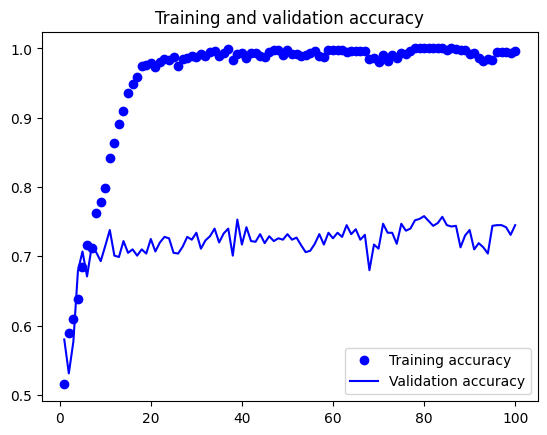

<Figure size 640x480 with 0 Axes>

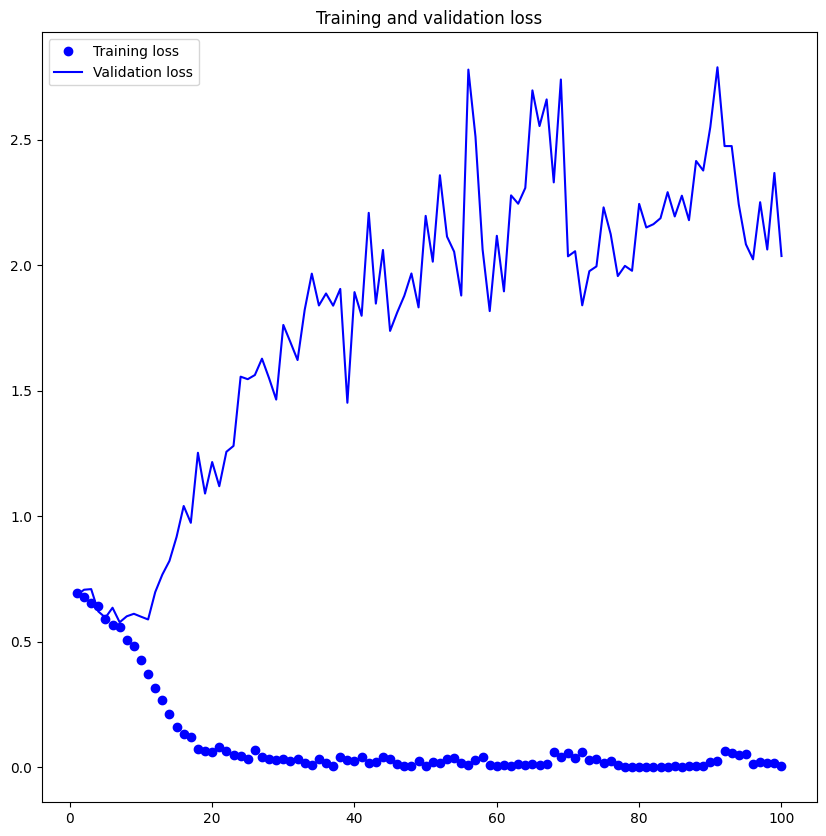

In [15]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluation of the model with the test set

In [16]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_d)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 55ms/step - loss: 0.5923 - accuracy: 0.6940
Test accuracy: 0.694


Q2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

Using data augmentation

Create a step for adding data augmentation to an image model.

In [17]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1500 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=667, end_index=2167)
make_subset("validation", start_index=2168, end_index=2668)
make_subset("test", start_index=2669, end_index=3168)

In [18]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Introducing some enhanced training pictures

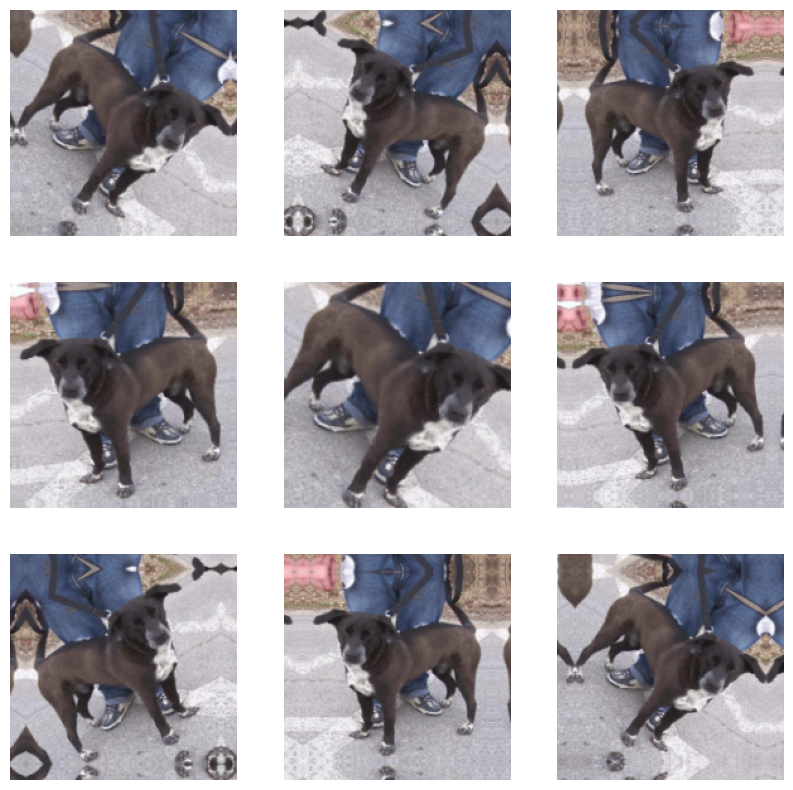

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_d.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Finding a new convolutional neural network with dropout and image augmentation

In [20]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Regularized convolutional neural network training

---



In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_d,
    epochs=200,
    validation_data=validation_d,
    callbacks=callbacks)

Epoch 1/200
63/63 [==============================] - 20s 285ms/step - loss: 0.6948 - accuracy: 0.5040 - val_loss: 0.6930 - val_accuracy: 0.4990
Epoch 2/200
63/63 [==============================] - 17s 272ms/step - loss: 0.6907 - accuracy: 0.5340 - val_loss: 0.6819 - val_accuracy: 0.5610
Epoch 3/200
63/63 [==============================] - 17s 268ms/step - loss: 0.6811 - accuracy: 0.5650 - val_loss: 0.6764 - val_accuracy: 0.5640
Epoch 4/200
63/63 [==============================] - 17s 270ms/step - loss: 0.6710 - accuracy: 0.6015 - val_loss: 0.6567 - val_accuracy: 0.6410
Epoch 5/200
63/63 [==============================] - 17s 268ms/step - loss: 0.6378 - accuracy: 0.6425 - val_loss: 0.6526 - val_accuracy: 0.6390
Epoch 6/200
63/63 [==============================] - 17s 271ms/step - loss: 0.6486 - accuracy: 0.6265 - val_loss: 0.6339 - val_accuracy: 0.6430
Epoch 7/200
63/63 [==============================] - 17s 267ms/step - loss: 0.6330 - accuracy: 0.6545 - val_loss: 0.6197 - val_accuracy:

Using the test dataset to evaluate the model

In [22]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_d)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 56ms/step - loss: 0.4625 - accuracy: 0.8050
Test accuracy: 0.805


Q3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

Step 3 constructed using validated training samples (2000 samples) and test sets (500 samples). According to my research, test accuracy is higher with 1500 photographs than with training samples of 1000 and 2000 photos.
Using 1000 training samples improves training accuracy.
retaining the 500-sample test and validation sets while increasing the training sample size to 2000.



In [23]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=667, end_index=2667)
make_subset("validation", start_index=2668, end_index=3168)
make_subset("test", start_index=3169, end_index=3669)

A new convolution with more training data, dropout, and picture augmentation

In [24]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_d,
    epochs=150,
    validation_data=validation_d,
    callbacks=callbacks)

Epoch 1/150
63/63 [==============================] - 19s 274ms/step - loss: 0.6959 - accuracy: 0.4885 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/150
63/63 [==============================] - 17s 267ms/step - loss: 0.6932 - accuracy: 0.5050 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/150
63/63 [==============================] - 17s 268ms/step - loss: 0.6932 - accuracy: 0.4825 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/150
63/63 [==============================] - 17s 270ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/150
63/63 [==============================] - 17s 268ms/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/150
63/63 [==============================] - 17s 264ms/step - loss: 0.6933 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/150
63/63 [==============================] - 17s 265ms/step - loss: 0.6933 - accuracy: 0.4830 - val_loss: 0.6931 - val_accuracy:

In [26]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_d)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 59ms/step - loss: 0.6929 - accuracy: 0.5000
Test accuracy: 0.500


VGG16 convolutional base activation

In [27]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [28]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Using a pretrained model for feature extraction without data augmentation

Finding the labels associated with the VGG16 characteristics

In [29]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_d)
val_features, val_labels =  get_features_and_labels(validation_d)
test_features, test_labels =  get_features_and_labels(test_d)

1/1 [==============================] - 0s 141ms/step


In [30]:
train_features.shape

(2000, 5, 5, 512)

In [31]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 16ms/step - loss: 11.0878 - accuracy: 0.9270 - val_loss: 4.8037 - val_accuracy: 0.9720
Epoch 2/20
63/63 [==============================] - 1s 11ms/step - loss: 1.9283 - accuracy: 0.9830 - val_loss: 3.9620 - val_accuracy: 0.9700
Epoch 3/20
63/63 [==============================] - 1s 11ms/step - loss: 2.5682 - accuracy: 0.9810 - val_loss: 3.2082 - val_accuracy: 0.9760
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 0.6708 - accuracy: 0.9940 - val_loss: 6.3799 - val_accuracy: 0.9680
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 0.6874 - accuracy: 0.9930 - val_loss: 4.8139 - val_accuracy: 0.9770
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 0.0433 - accuracy: 0.9970 - val_loss: 7.5338 - val_accuracy: 0.9720
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 1.0776 - accuracy: 0.9930 - val_loss: 6.1233 - val_accuracy: 0.9750
Epoch 8/20
63/63

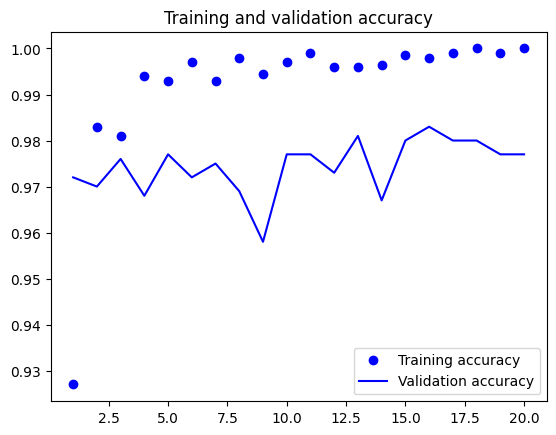

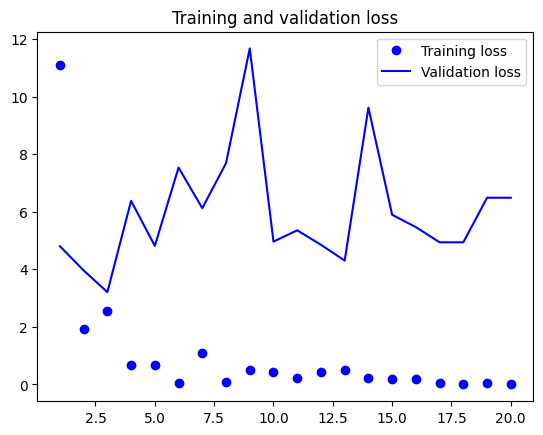

In [32]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Instantiation and freezing of the VGG16 convolutional base

In [33]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [34]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [35]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


The model is currently operating using a classifier and augmentation to the convolution basis.

In [36]:

augmentation2 = keras.Sequential(
 [
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(0.1),
 layers.RandomZoom(0.2),
 ]
)
input22 = keras.Input(shape=(180, 180, 3))
x1 = augmentation2(input22)
x1 =keras.layers.Lambda(
 lambda x: keras.applications.vgg16.preprocess_input(x))(x1)
x1 = conv_base(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(256)(x1)
x1 = layers.Dropout(0.5)(x1)
outputs = layers.Dense(1, activation="sigmoid")(x1)
model = keras.Model(input22, outputs)
model.compile(loss="binary_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])


In [37]:

callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="features_extraction_with_augmentation2.keras",
 save_best_only=True,
 monitor="val_loss"
 )
]
history = model.fit(
 train_d,
 epochs=10,
 validation_data=validation_d,
 callbacks=callbacks
)

Epoch 1/10
63/63 [==============================] - 37s 576ms/step - loss: 15.5075 - accuracy: 0.9000 - val_loss: 3.4014 - val_accuracy: 0.9760
Epoch 2/10
63/63 [==============================] - 35s 564ms/step - loss: 7.3697 - accuracy: 0.9405 - val_loss: 2.6820 - val_accuracy: 0.9770
Epoch 3/10
63/63 [==============================] - 35s 559ms/step - loss: 6.4280 - accuracy: 0.9505 - val_loss: 4.7332 - val_accuracy: 0.9660
Epoch 4/10
63/63 [==============================] - 35s 559ms/step - loss: 4.3981 - accuracy: 0.9605 - val_loss: 3.1707 - val_accuracy: 0.9760
Epoch 5/10
63/63 [==============================] - 35s 560ms/step - loss: 4.7944 - accuracy: 0.9625 - val_loss: 3.5123 - val_accuracy: 0.9800
Epoch 6/10
63/63 [==============================] - 35s 563ms/step - loss: 3.3875 - accuracy: 0.9685 - val_loss: 2.9896 - val_accuracy: 0.9810
Epoch 7/10
63/63 [==============================] - 35s 563ms/step - loss: 3.4400 - accuracy: 0.9705 - val_loss: 4.5672 - val_accuracy: 0.974

In [38]:
augmentation2 = keras.Sequential(
 [
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(0.1),
 layers.RandomZoom(0.2),
 ]
)
input22 = keras.Input(shape=(180, 180, 3))
x1 = augmentation2(input22)
# Specify the output_shape argument for the Lambda layer
x1 =keras.layers.Lambda(
 lambda x: keras.applications.vgg16.preprocess_input(x),
 output_shape=(180, 180, 3))(x1) # Output shape is same as input shape
x1 = conv_base(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(256)(x1)
x1 = layers.Dropout(0.5)(x1)
outputs = layers.Dense(1, activation="sigmoid")(x1)
model = keras.Model(input22, outputs)
model.compile(loss="binary_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

Enhancing a model that has already been trained


Everything is frozen except for the fourth layer from the bottom.

In [39]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [40]:

model.compile(loss="binary_crossentropy",
 optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
 metrics=["accuracy"])
callbackstu = [
 keras.callbacks.ModelCheckpoint(
 filepath="fine_tuning.keras",
 save_best_only=True,
 monitor="val_loss")
]
historytune = model.fit(
 train_d,
 epochs=30,
 validation_data=validation_d,
 callbacks=callbackstu)

Epoch 1/30
63/63 [==============================] - 50s 771ms/step - loss: 3.6918 - accuracy: 0.7640 - val_loss: 0.6801 - val_accuracy: 0.9300
Epoch 2/30
63/63 [==============================] - 47s 755ms/step - loss: 0.9931 - accuracy: 0.8825 - val_loss: 0.3810 - val_accuracy: 0.9470
Epoch 3/30
63/63 [==============================] - 48s 759ms/step - loss: 0.6263 - accuracy: 0.9005 - val_loss: 0.2508 - val_accuracy: 0.9590
Epoch 4/30
63/63 [==============================] - 47s 750ms/step - loss: 0.4266 - accuracy: 0.9210 - val_loss: 0.2090 - val_accuracy: 0.9590
Epoch 5/30
63/63 [==============================] - 47s 748ms/step - loss: 0.2937 - accuracy: 0.9345 - val_loss: 0.1636 - val_accuracy: 0.9620
Epoch 6/30
63/63 [==============================] - 47s 751ms/step - loss: 0.2226 - accuracy: 0.9380 - val_loss: 0.1634 - val_accuracy: 0.9630
Epoch 7/30
63/63 [==============================] - 47s 754ms/step - loss: 0.1726 - accuracy: 0.9525 - val_loss: 0.1545 - val_accuracy: 0.9630

In [41]:

model_tuning = keras.models.load_model("fine_tuning.keras",safe_mode=False)
test_loss, test_acc = model.evaluate(test_d)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 13s 395ms/step - loss: 0.1982 - accuracy: 0.9730
Test accuracy: 0.973
